To install rascal:
(NOTE: See the top-level README for the most up-to-date installation instructions.)
+ mkdir ../build 
+ cd build
+ cmake -DCMAKE_BUILD_TYPE=Release -DBUILD_TESTS=ON ..
+ make -j 4
+ make install

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import os, sys
from ase.io import read
sys.path.insert(0,"../build/")

import sys
import time
import rascal
import json

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
import sys

import json

from rascal.representations import SphericalExpansion, SOAP
from rascal.utils import ostream_redirect

In [2]:
frames = read('./data/small_molecules-1000.xyz',':')

# Density expansion

In [3]:
test_hypers = {"interaction_cutoff": 6.0, "cutoff_smooth_width": 1.0, "max_radial": 10, "max_angular": 8, "gaussian_sigma_type": "Constant", "gaussian_sigma_constant": 0.5}

In [9]:
sph_expn = SphericalExpansion(**test_hypers)

In [13]:
with ostream_redirect():
    expansions = sph_expn.transform(frames)

In [14]:
X = expansions.get_feature_matrix().T

In [15]:
X.shape

(8977, 4050)

# SOAP: Radial spectrum

In [142]:
hypers = dict(soap_type="RadialSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [144]:
Nframes,ids,X = compute_representation(soap,frames)

In [147]:
X.shape

(17743, 24)

# Learning the formation energies of small molecules

In [155]:
# Load the small molecules 
frames = read('./data/small_molecules-1000.xyz',':')

## learning utilities

In [ ]:
# !pip install numba
from numba import njit,prange,void,float64,float32,int32,int64,vectorize,jit,config,threading_layer
import numpy as np
import math

In [175]:
@jit(nopython=True,nogil=True,parallel=True)
def get_strides(ids):
    subids = np.unique(ids[:,0])
    N = len(subids)
    Nelem = np.zeros((N+1,),np.int32)
    for ii in ids[:,0]:
        Nelem[ii+1] += 1
    Nelem = np.cumsum(Nelem)
    return N,Nelem

@jit(nopython=True,nogil=True,cache=True)
def power_kernel(x,y,zeta):
    return math.pow(np.vdot(x,y),zeta)
@jit(nopython=True,nogil=True,parallel=True)
def sum_power_diff_species(out, zeta, desc1, ids1, desc2, ids2):
    N,Nelem = get_strides(ids1)
    M,Melem = get_strides(ids2)
    for iframe1 in prange(N):
        st,nd = Nelem[iframe1],Nelem[iframe1+1]
        d1 = desc1[st:nd]
        sp1 = ids1[st:nd,1]
        n = nd-st
        for iframe2 in prange(M):
            st2,nd2 = Melem[iframe2],Melem[iframe2+1]
            d2 = desc2[st2:nd2]
            sp2 = ids2[st2:nd2,1]
            m = nd2-st2
            for it in range(n):
                for jt in range(m):
                    if sp1[it] != sp2[jt]: continue
                    out[iframe1,iframe2] += power_kernel(d1[it],d2[jt],zeta)

@jit(nopython=True,nogil=True,parallel=True)
def sum_power_diff_species_self(out, zeta, desc1, ids1):
    N,Nelem = get_strides(ids1)
    for iframe1 in prange(N):
        st,nd = Nelem[iframe1],Nelem[iframe1+1]
        d1 = desc1[st:nd]
        sp1 = ids1[st:nd,1]
        n = nd-st

        for it in range(n):
            for jt in range(n):
                if sp1[it] != sp1[jt]: continue
                out[iframe1,iframe1] += power_kernel(d1[it],d1[jt],zeta)

        for iframe2 in range(iframe1+1,N):
            st2,nd2 = Nelem[iframe2],Nelem[iframe2+1]
            d2 = desc1[st2:nd2]
            sp2 = ids1[st2:nd2,1]
            m = nd2-st2
            for it in range(n):
                for jt in range(m):
                    if sp1[it] != sp2[jt]: continue
                    tmp = power_kernel(d1[it],d2[jt],zeta)
                    out[iframe1,iframe2] += tmp
                    out[iframe2,iframe1] += tmp

                    
@njit(parallel=True)
def sum_power_no_species(out, zeta, desc1, ids1, desc2, ids2):
    N,Nelem = get_strides(ids1)
    M,Melem = get_strides(ids2)
    for iframe1 in prange(N):
        st,nd = Nelem[iframe1],Nelem[iframe1+1]
        d1 = desc1[st:nd]
        n = nd-st
        for iframe2 in prange(M):
            st2,nd2 = Melem[iframe2],Melem[iframe2+1]
            d2 = desc2[st2:nd2]
            m = nd2-st2
            for it in range(n):
                for jt in range(m):
                    out[iframe1,iframe2] += power_kernel(d1[it],d2[jt],zeta)
            out[iframe1,iframe2] /= n*m

@jit(nopython=True,nogil=True,parallel=True)
def sum_power_no_species_self(out, zeta, desc1, ids1):
    N,Nelem = get_strides(ids1)
    for iframe1 in prange(N):
        st,nd = Nelem[iframe1],Nelem[iframe1+1]
        d1 = desc1[st:nd]
        sp1 = ids1[st:nd,1]
        n = nd-st

        for it in range(n):
            for jt in range(n):
                out[iframe1,iframe1] += power_kernel(d1[it],d1[jt],zeta)
        out[iframe1,iframe1] /= n**2
        for iframe2 in range(iframe1+1,N):
            st2,nd2 = Nelem[iframe2],Nelem[iframe2+1]
            d2 = desc1[st2:nd2]
            sp2 = ids1[st2:nd2,1]
            m = nd2-st2
            for it in range(n):
                for jt in range(m):
                    tmp = power_kernel(d1[it],d2[jt],zeta)
                    out[iframe1,iframe2] += tmp
                    out[iframe2,iframe1] += tmp
            out[iframe1,iframe2] /= n*m
            out[iframe2,iframe1] /= n*m                    
                    
def get_ids(frames):
    ids = []
    for iframe,frame in enumerate(frames):
        atom_types = frame.get_atomic_numbers()
        ids.append(np.concatenate([iframe * np.ones((len(frame),1),int), atom_types[:,None]],axis=1))
    ids = np.concatenate(ids)
    return ids

In [181]:
def compute_representation(representation,frames):
    Nframes = len(frames)
    ids = get_ids(frames)
    expansions = soap.transform(frames)
    X = expansions.get_feature_matrix().T
    norm = np.linalg.norm(X,axis=1)
    X /= norm[:,None]
    return Nframes,ids,X

def compute_kernel(zeta, Nframes1,ids1,X1, Nframes2=None,ids2=None,X2=None):
    if Nframes2 is None:
        kernel = np.zeros((Nframes1,Nframes1))
        sum_power_no_species_self(kernel,zeta,X1,ids1)
    else:
        kernel = np.zeros((Nframes1,Nframes2))
        sum_power_no_species(kernel,zeta,X1,ids1,X2,ids2)
    return kernel

def extract_energy(frames):
    prop = [[]]*len(frames)
    for ii,cc in enumerate(frames):
        prop[ii] = cc.info['dft_formation_energy_per_atom_in_eV']
    y = np.array(prop)
    return y

def split_dataset(frames, test_fraction, seed=10):
    N = len(frames)
    ids = np.arange(N)
    np.random.seed(seed)
    np.random.shuffle(ids)
    Ntrain = int(N*test_fraction)
    train = ids[:Ntrain]
    test = ids[Ntrain:]
    targets = extract_energy(frames)
    return [frames[ii] for ii in train],targets[train],[frames[ii] for ii in test],targets[test]

def get_mae(ypred,y):
    return np.mean(np.abs(ypred-y))
def get_rmse(ypred,y):
    return np.sqrt(np.mean((ypred-y)**2))
def get_sup(ypred,y):
    return np.amax(np.abs((ypred-y)))
def get_r2(y_pred,y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,dtype=np.float64)
    denominator = (weight * (y_true - np.average(
        y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,dtype=np.float64)
    output_scores = 1 - (numerator / denominator)
    return np.mean(output_scores)


score_func = dict(
    MAE=get_mae,
    RMSE=get_rmse,
    SUP=get_sup,
    R2=get_r2,
)

def get_score(ypred,y):
    scores = {}
    for k,func in score_func.items():
        scores[k] = func(ypred,y)
    return scores

class KRR(object):
    def __init__(self,zeta,weights,representation,Nframes,ids,X):
        self.weights = weights
        self.representation = representation
        self.zeta = zeta
        self.Nframes = Nframes
        self.ids = ids
        self.X = X
        
    def predict(self,frames):
        Nframes,ids,X = compute_representation(self.representation,frames)
        kernel = compute_kernel(self.zeta , self.Nframes, self.ids, self.X,Nframes,ids,X)
        return np.dot(self.weights,kernel)
    
def train_krr_model(zeta,Lambda,representation,frames,y,jitter=1e-8):
    Nframes,ids,X = compute_representation(representation,frames)
    kernel = compute_kernel(zeta,Nframes,ids,X)    
    # adjust the kernel so that it is properly scaled
    delta = np.std(y) / np.mean(kernel.diagonal())
    kernel[np.diag_indices_from(kernel)] += Lambda**2 / delta **2 + jitter
    # train the krr model
    weights = np.linalg.solve(kernel,y)
    model = KRR(zeta, weights,representation,Nframes,ids,X)
    return model,kernel



## With the Radial spectrum

In [194]:
hypers = dict(soap_type="RadialSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=0, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [195]:
frames_train, y_train, frames_test, y_test = split_dataset(subset,0.8)

In [201]:
zeta = 2
Lambda = 5e-4
krr,k = train_krr_model(zeta, Lambda, soap, frames_train, y_train)

In [202]:
y_pred = krr.predict(frames_test)
get_score(y_pred, y_test)

{'MAE': 0.012005551492167105,
 'RMSE': 0.01658363680439145,
 'SUP': 0.059362219406213335,
 'R2': 0.992299387594359}

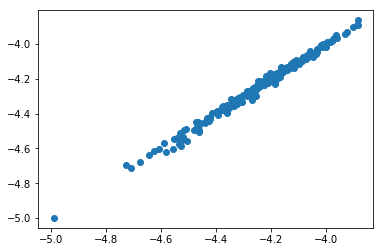

In [203]:
plt.plot(y_pred, y_test,'o')

## With the  Power spectrum

In [204]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=4, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [205]:
frames_train, y_train, frames_test, y_test = split_dataset(subset,0.8)

In [206]:
zeta = 2
Lambda = 5e-3
krr,k = train_krr_model(zeta, Lambda, soap, frames_train, y_train)

In [207]:
y_pred = krr.predict(frames_test)
get_score(y_pred, y_test)

{'MAE': 0.011644755962830617,
 'RMSE': 0.018344216429559114,
 'SUP': 0.14826361768318286,
 'R2': 0.9905775456856754}

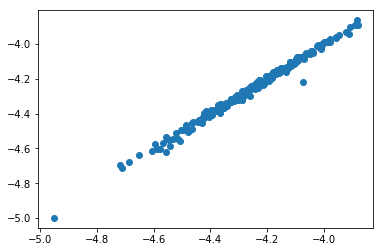

In [208]:
plt.plot(y_pred, y_test,'o')